In [76]:
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from transforms import *
from train import *
from utils import *
from models import *
from dataset import *
from learner import *

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn

import optuna
import numpy as np

EPOCHS = 50
LEARNING_RATE = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using: {device}')


preprocess = PreprocessPipelineRNN(target_sr=16000)
transforms = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=2560, hop_length=512),
    torchaudio.transforms.AmplitudeToDB(stype="power")
])
augments = RandomCombine(0.5,max_files=4)


train_dir = os.path.join(Path(os.getcwd()).parent, "data/raw/IRMAS_Training_Data")
valid_dir = os.path.join(Path(os.getcwd()).parent, "data/raw/IRMAS_Validation_Data")


train_dl = get_loader(train_dir, preprocess, augments, 
                      transforms, bs=16, rnn=True, device=device, 
                      subset="train")

valid_dl = get_loader(valid_dir, preprocess, augments=None,
                      transforms=transforms, bs=16, rnn=True, 
                      device=device, 
                      subset="valid")


model = RNN(128,64,3,11, device)
optimizer = optim.Adam
loss_fn = FocalLoss()

learn = Learner(train_dl, valid_dl, model, loss_fn)
#learn.fit(50, LEARNING_RATE, optimizer)

Using: cpu


In [3]:
dst = IRMASDataset(train_dir, preprocess=preprocess, transforms=transforms, augments=augments)

In [8]:
import IPython.display as ipd

In [49]:
target_sr = 16000

i = np.random.randint(0, len(dst.files))
signal1 = preprocess(*torchaudio.load(dst.files[i]))
ipd.Audio(signal1, rate=target_sr)

In [50]:
j = np.random.randint(0, len(dst.files))
signal2 = preprocess(*torchaudio.load(dst.files[j]))
ipd.Audio(signal2, rate=target_sr)

In [53]:
signal3 = signal1+signal2
ipd.Audio(signal3, rate=target_sr)

In [54]:
import matplotlib.pyplot as plt

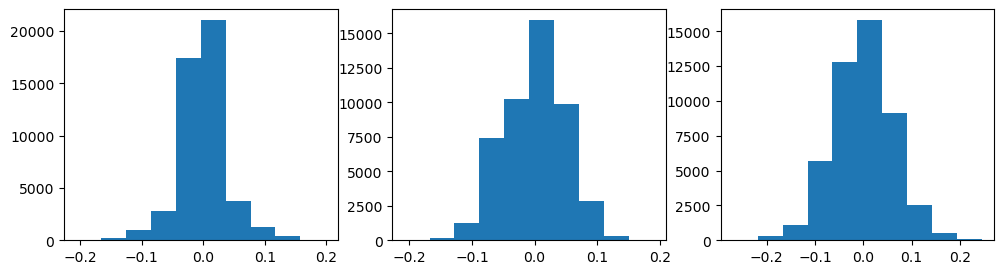

In [55]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.hist(signal1);
plt.subplot(132)
plt.hist(signal2);
plt.subplot(133)
plt.hist(signal3);

In [56]:
signal1.min(), signal1.max()

(tensor(-0.2061), tensor(0.1984))

In [57]:
signal2.min(), signal2.max()

(tensor(-0.2072), tensor(0.1898))

In [58]:
signal3.min(), signal3.max()

(tensor(-0.2695), tensor(0.2448))

In [77]:
spec1 = transforms(signal1)
spec2 = transforms(signal2)
spec3 = transforms(signal3)

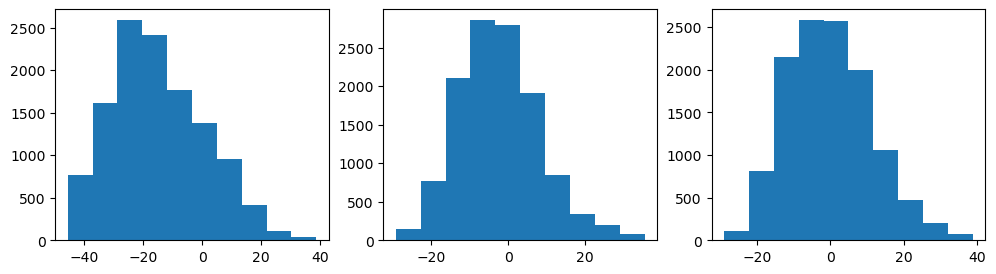

In [78]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.hist(spec1.ravel());
plt.subplot(132)
plt.hist(spec2.ravel());
plt.subplot(133)
plt.hist(spec3.ravel());

In [79]:
signal3_scaled = ((signal3 - signal3.min()) / (signal3.max() - signal3.min())) * 2 -1 

In [80]:
spec3.min(), spec3.max()

(tensor(-28.9426), tensor(38.7256))

In [81]:
spec3_scaled.min(), spec3_scaled.max()

(tensor(-28.9426), tensor(38.7256))

(array([ 113.,  809., 2148., 2580., 2574., 1992., 1061.,  478.,  201.,
          76.]),
 array([-28.9426403 , -22.17581558, -15.40899086,  -8.64216518,
         -1.8753407 ,   4.89148426,  11.65830898,  18.42513466,
         25.19195938,  31.9587841 ,  38.72560883]),
 <BarContainer object of 10 artists>)

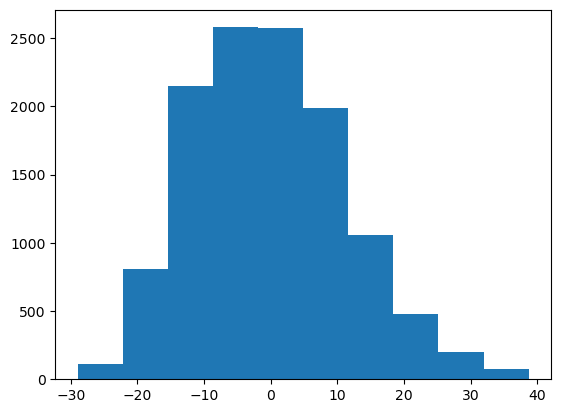

In [71]:
spec3_scaled = transforms(signal3)
plt.hist(spec3_scaled.ravel())

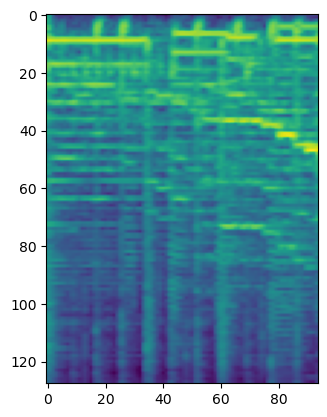

In [73]:
plt.imshow(spec3_scaled.squeeze())

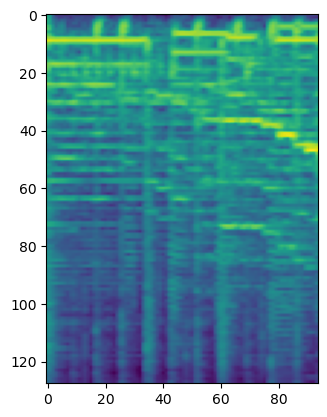

In [85]:
mean = spec3.mean()
stdev = spec3.std()

spec3_scaled = (spec3 - mean) / stdev

plt.imshow(spec3_scaled.squeeze())

(array([ 113.,  809., 2148., 2580., 2574., 1992., 1061.,  478.,  201.,
          76.]),
 array([-2.53338718, -1.93654335, -1.33969951, -0.74285573, -0.14601192,
         0.45083189,  1.04767573,  1.64451957,  2.24136329,  2.83820724,
         3.43505096]),
 <BarContainer object of 10 artists>)

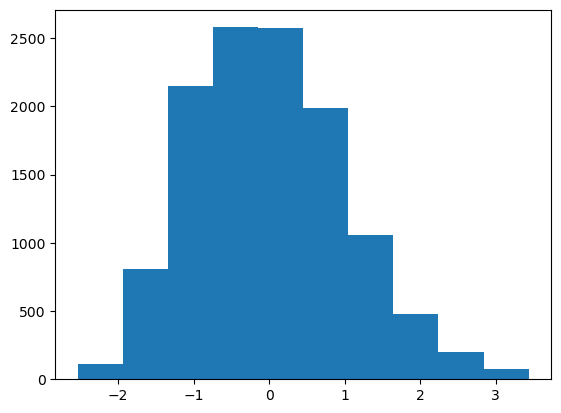

In [86]:
plt.hist(spec3_scaled.ravel())

In [92]:
class Normalize:

    def __init__(self, mean=None, stdev=None):
        
        self.mean = mean
        self.stdev = stdev
    
    def __call__(self,signal):
        
        if self.mean is None and self.stdev is None:
            mean = torch.mean(signal).item()
            stdev = torch.std(signal).item()
        
        return (signal - mean) / stdev

(array([ 113.,  809., 2148., 2580., 2574., 1992., 1061.,  478.,  201.,
          76.]),
 array([-2.53338718, -1.93654335, -1.33969951, -0.74285573, -0.14601192,
         0.45083189,  1.04767573,  1.64451957,  2.24136329,  2.83820724,
         3.43505096]),
 <BarContainer object of 10 artists>)

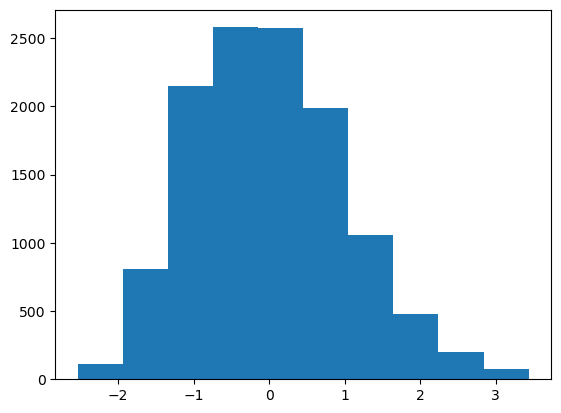

In [94]:
norm = Normalize()
plt.hist(norm(spec3).ravel())